In [1]:
import numpy as np
from numba import njit
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
def transiente(prox):
    """ Argumentos: 
        prox -- proximidad a un punto de bifurcación del diagrama, escogido manualmente
                debe ser un int del 1 al 10. 

        Retorna:
        N -- número de puntos en la integración del sistema
        T -- transiente a ser considerada para llegar a la estabilización
    """
    # Número de puntos y tamaño de paso en la integración del sistema: 
    n = 300000 + prox * 100000
    t = int(round(n*0.4))

    return n, t

In [50]:
@njit
def f(a, b, x):
    return b*x + 0.5*(a-b)*(abs(x+1) - abs(x-1))


@njit
def dx_dt(a, b, k, α, x, y):
    return k*α*(y - x - f(a, b, x))


@njit
def dy_dt(k, x, y, z):
    return k*(x - y + z)


@njit
def dz_dt(k, β, γ, y, z):
    return -k*(β*y + γ*z)


@njit
def rk_solver(a, b, k, α, β, γ, x, y, z, n_steps, transient_drop, h=0.001):
    trajectory = np.empty((n_steps - transient_drop, 3), dtype=np.float64)

    idx = 0
    for t in range(1, n_steps + 1):
        k1 = dx_dt(a, b, k, α, x, y)
        k2 = dx_dt(a, b, k, α, x + 0.5 * k1 * h, y)
        k3 = dx_dt(a, b, k, α, x + 0.5 * k2 * h, y)
        k4 = dx_dt(a, b, k, α, x + k3 * h, y)
        px = x + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4) * h

        k1 = dy_dt(k, x, y, z)
        k2 = dy_dt(k, x, y + 0.5 * k1 * h, z)
        k3 = dy_dt(k, x, y + 0.5 * k2 * h, z)
        k4 = dy_dt(k, x, y + k3 * h, z)
        py = y + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4) * h

        k1 = dz_dt(k, β, γ, y, z)
        k2 = dz_dt(k, β, γ, y, z + 0.5 * k1 * h)
        k3 = dz_dt(k, β, γ, y, z + 0.5 * k2 * h)
        k4 = dz_dt(k, β, γ, y, z + k3 * h)
        pz = z + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4) * h
        
        if t > transient_drop:
            trajectory[idx, 0] = px
            trajectory[idx, 1] = py
            trajectory[idx, 2] = pz
            idx += 1

        x, y, z = px, py, pz

    return trajectory

In [51]:
def plot(a, b, k, α, β, γ, init_cond, proximity, row, col, lyapunov, base_path=None):
    n_steps, transient_drop = transiente(proximity)

    points = rk_solver(a, b, k, α, β, γ,
                       init_cond[0], init_cond[1], init_cond[2], n_steps, transient_drop)

    # elevation, azimuth = np.random.randint(0, 360, (2,))
    elevation, azimuth = 45, 45

    ax = plt.axes(projection='3d')

    ax.plot3D(points[:, 0], points[:, 1], points[:, 2], 'black', linewidth=0.5)
    ax.set_axis_off()
    ax.view_init(elev=elevation, azim=azimuth)

    if base_path:
        plt.savefig(f'{base_path}/{row}_{col}_{lyapunov}.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
    return points

In [52]:
lyapunov_exp_mat = np.load('../Data/lyapunov_exp.npy')
alpha_gamma_mat = np.load('../Data/alpha_gamma.npy')

# α y γ variable
β = 1000.0
a = -8/7
b = -5/7
k = 1
init_cond = [1.1, 0.12, 0.01]

(480000, 3)


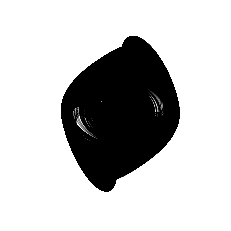

In [53]:
i, j = 598, 192
α, γ = alpha_gamma_mat[i, j]
points = plot(a, b, k, α, β, γ, init_cond, 5, i, j, lyapunov_exp_mat[i, j])